In [1]:
#pip install --upgrade pip

In [2]:
#pip install scikit-learn

In [3]:
#pip install statsmodels

In [4]:
import itertools
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [5]:
# Load iris dataset
data = load_iris()
X_full = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)  # Species as numeric labels (0, 1, 2)

<Figure size 600x400 with 0 Axes>

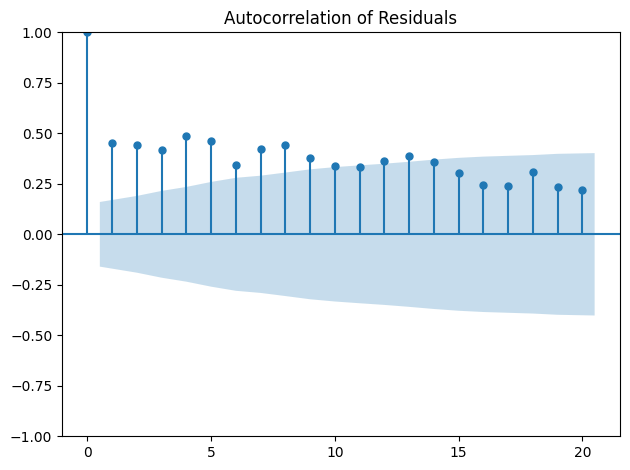

<Figure size 600x400 with 0 Axes>

In [6]:
# Fit linear regression model for the full model
model = LinearRegression()
model.fit(X_full, y)
y_pred = model.predict(X_full)
residuals = y - y_pred

# Residuals vs Fitted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Autocorrelation of residuals
plt.figure(figsize=(6, 4))
plot_acf(residuals, lags=20)
plt.title("Autocorrelation of Residuals")
plt.tight_layout()
plt.show()

# Q-Q Plot for residuals
plt.figure(figsize=(6, 4))
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

In [7]:
# All non-empty combinations of the features
feature_names = X_full.columns.tolist()
combinations = []
for r in range(1, len(feature_names) + 1):
    combinations.extend(itertools.combinations(feature_names, r))

In [8]:
results = []

In [9]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# BIC calculation helper
def compute_bic(n, mse, k):
    return n * np.log(mse) + k * np.log(n)

In [11]:
# Try all combinations
for combo in combinations:
    X = X_full[list(combo)]
    bic_scores = []
    coefs = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        n = len(y_test)
        k = X.shape[1] + 1  # Number of parameters (coefficients + intercept)
        bic = compute_bic(n, mse, k)
        bic_scores.append(bic)
        coefs.append(model.coef_)
    
    avg_bic = np.mean(bic_scores)
    avg_coef = np.mean(coefs, axis=0)
    
    results.append({
        "Features": combo,
        "BIC": avg_bic,
        "Coefficients": avg_coef
    })

In [12]:
# Convert results to DataFrame and sort by BIC
df_results = pd.DataFrame(results)
df_results["Features"] = df_results["Features"].apply(lambda x: ", ".join(x))
df_results = df_results.sort_values(by="BIC")

# Show results
print(df_results.to_string(index=False))# Find and print the best model based on BIC

                                                                Features        BIC                                                                           Coefficients
                                     petal length (cm), petal width (cm) -79.966119                                              [0.17796320237066632, 0.6310854591966504]
                                                        petal width (cm) -79.935376                                                                    [1.028084679087288]
                                      sepal width (cm), petal width (cm) -78.272210                                              [-0.16548923827800194, 0.993352500599156]
                  sepal length (cm), petal length (cm), petal width (cm) -78.159707                        [-0.13614298020063995, 0.25187698514269174, 0.5870393766101574]
                   sepal width (cm), petal length (cm), petal width (cm) -77.208867                         [-0.11236946402530915, 0.148770655417

In [13]:
# Find and print the best model based on BIC
best_model = df_results.iloc[0]

print("\nBest Model Based on BIC:")
print(f"Features     : {best_model['Features']}")
print(f"BIC          : {best_model['BIC']:.2f}")
print(f"Coefficients : {best_model['Coefficients']}")


Best Model Based on BIC:
Features     : petal length (cm), petal width (cm)
BIC          : -79.97
Coefficients : [0.1779632  0.63108546]
